In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim

import pandas as pd
plt.rcParams.update({'font.size': 22})
pd.set_option('display.float_format', lambda x: '%.2e' % x)
FELTOR_PATH="../feltor" # path to the feltor library

In [2]:
# Create an inputfile for the geometry_diag.cu program to plot an example grid and the delta function
def create_geometry_input() :
    geometry_diag_json = {
    "grid":
    {
        "n" : 3,
        "Nx" : 80,
        "Ny" : 80,
        "Nz" : 20,
        "npsi" : 3,
        "Npsi": 32,
        "Neta": 640,
        "scaleR" : [1.4, 1.3],
        "scaleZ" : [2, 2]
    },
    "boundary":
    {
        "wall":
        {
            "type" : "heaviside",
            "boundary" : 1.1,
            "alpha" : 0.2
        },
        "sheath":
        {
            "boundary" : 0.0625,
            "alpha" : 0.015625,
            "max_angle": 1e-3
        }
    },
    "magnetic_field":
    {
        "input" : "params",
        "params": mag.select("COMPASS/compass_2X.json")
    },
    "width-factor" : 0.2
    }
    return geometry_diag_json

In [3]:
geometry_sim = simplesim.Manager( executable=FELTOR_PATH+"/inc/geometries/geometry_diag",
                              directory="Averages/geometry", filetype="nc")
# geometry_sim.delete_all()

Running simulation ...a311d90da.nc
Running simulation ...196b05a25.nc
Running simulation ...a1af37560.nc


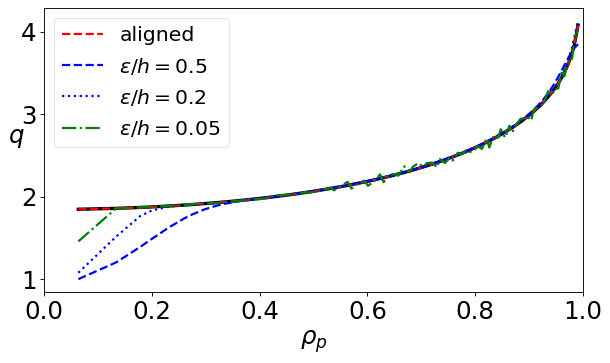

In [4]:
# plot q-profile for various methods
geometry_input = create_geometry_input()
geometry_input["magnetic_field"]["params"] = mag.select("COMPASS/compass_2X.json")
geometry_input["width-factor"] = 0.5
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
frows = 1
fcols = 1

rho_p = ncin["rho_p"][:]
lcfs = np.argmax( rho_p[np.where( rho_p < 1)])
rho = rho_p[:lcfs]
dvdpsip = ncin["dvdpsip"][:lcfs]
qprof_ana = ncin["q-profile"][:lcfs]
R_0 = geometry_input["magnetic_field"]["params"]["R_0"]                              
                              
qprof_num_eta = 1./4./np.pi**2/R_0*dvdpsip* ncin["BFieldP_fsa"][:lcfs]
qprof_num_avg = ncin["q-profile-avg"][:lcfs]

fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1.618*5,frows*5),dpi= 80, facecolor='w', edgecolor='k')

im = ax.plot(rho, qprof_ana, color = 'k', ls='-', lw=3) 
im = ax.plot(rho, qprof_num_eta, color = 'red', ls='--', lw=2, label="aligned") 
im = ax.plot(rho, qprof_num_avg, color = 'blue', ls='--', lw=2, label=r"$\varepsilon/h = 0.5$") 

ncin.close()
##########################################
geometry_input["width-factor"] = 0.2
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
qprof_num_avg = ncin["q-profile-avg"][:lcfs]
im = ax.plot(rho, qprof_num_avg, color = 'blue', ls=':', lw=2, label=r"$\varepsilon/h = 0.2$") 
##########################################
geometry_input["width-factor"] = .05
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
qprof_num_avg = ncin["q-profile-avg"][:lcfs]
im = ax.plot(rho, qprof_num_avg, color = 'green', ls='-.', lw=2, label=r"$\varepsilon/h = 0.05$") 

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper left',numpoints=1,ncol=1,
                   fontsize='small',framealpha=0.5)
ax.set_xlabel( r"$\rho_p$")
ax.set_xlim([0,1])
ax.set_ylabel( r"$q$",rotation=0)
plt.tight_layout()
plt.savefig( "q-profile.png", bbox_inches="tight")
plt.show()

Running simulation ...49b1bdc6e.nc
Running simulation ...ab7daa2bc.nc
Running simulation ...f6cf16af7.nc


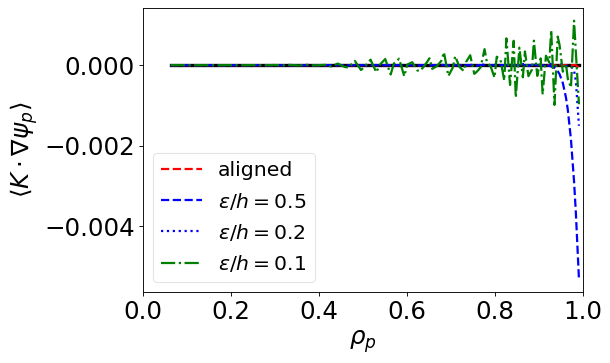

In [5]:
# plot q-profile for various methods
geometry_input = create_geometry_input()
geometry_input["magnetic_field"]["params"] = mag.select("COMPASS/compass_1X.json")
geometry_input["width-factor"] = 0.5
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
frows = 1
fcols = 1

rho_p = ncin["rho_p"][:]
lcfs = np.argmax( rho_p[np.where( rho_p < 1)])
rho = rho_p[:lcfs]
qprof_ana = np.zeros( lcfs)                             
                              
qprof_num_eta = ncin["CurvatureNablaBGradPsip_fsa"][:lcfs] + ncin["CurvatureKappaGradPsip_fsa"][:lcfs]
qprof_num_avg = ncin["CurvatureNablaBGradPsip_fsa-avg"][:lcfs] + ncin["CurvatureKappaGradPsip_fsa-avg"][:lcfs]


fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1.618*5,frows*5),dpi= 80, facecolor='w', edgecolor='k')

im = ax.plot(rho, qprof_ana, color = 'k', ls='-', lw=3) 
im = ax.plot(rho, qprof_num_eta, color = 'red', ls='--', lw=2, label="aligned") 
im = ax.plot(rho, qprof_num_avg, color = 'blue', ls='--', lw=2, label=r"$\varepsilon/h = 0.5$") 

ncin.close()
##########################################
geometry_input["width-factor"] = 0.2
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
qprof_num_avg = ncin["CurvatureNablaBGradPsip_fsa-avg"][:lcfs] + ncin["CurvatureKappaGradPsip_fsa-avg"][:lcfs]
im = ax.plot(rho, qprof_num_avg, color = 'blue', ls=':', lw=2, label=r"$\varepsilon/h = 0.2$") 
##########################################
geometry_input["width-factor"] = .1
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
qprof_num_avg = ncin["CurvatureNablaBGradPsip_fsa-avg"][:lcfs] + ncin["CurvatureKappaGradPsip_fsa-avg"][:lcfs]
im = ax.plot(rho, qprof_num_avg, color = 'green', ls='-.', lw=2, label=r"$\varepsilon/h = 0.1$") 

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=1,
                   fontsize='small',framealpha=0.5)
ax.set_xlabel( r"$\rho_p$")
ax.set_xlim([0,1])
ax.set_ylabel( r"$\langle K\cdot \nabla\psi_p\rangle$",rotation=90)
plt.tight_layout()
plt.savefig( "curvature.png", bbox_inches="tight")
plt.show()

In [6]:
# Construct the Gaussian weights on our grids
def gauss_weights1d( js) :
    n = js["npsi"]
    Nx = js["Npsi"]
    lx = 10 # length drops out in relative error BUT NOT ABSOLUTE
    hx = lx/Nx
    (x,w) = np.polynomial.legendre.leggauss(js[F"npsi"])
    weights1dX = np.tile( w, js["Npsi"])*hx/2
    return weights1dX

In [7]:
def compare_q( simfile) :
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    
    rho_p = ncin["rho_p"][:]
    lcfs = np.argmax( rho_p[np.where( rho_p < 1)])
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    weights = gauss_weights1d( gg)[:lcfs]
    dvdpsip = ncin["dvdpsip"][:lcfs]
    R_0 = geometry_input["magnetic_field"]["params"]["R_0"] 
    num = 1./4./np.pi**2/R_0*dvdpsip* ncin["BFieldP_fsa"][:lcfs]
    sol = ncin["q-profile"][:lcfs]
    diff = num - sol
#     norm_diff = np.max(np.abs(diff))
    norm_diff = np.sqrt(np.sum( diff[:]**2*weights ))
#     norm_sol = np.max(np.abs(sol))
    norm_sol = np.sqrt(np.sum( sol[:]**2*weights ))
    return norm_diff/ norm_sol

In [8]:
#define conversion function 
def orderToString(x): 
    if np.isnan(x) : return 'n/a'
    return'%.2f'% x

def errorToString(x):
    return '%.2e' % x

In [9]:
# We could also lower Nx and Ny to get faster convergence to a constant
lines = list()
for Neta in [160,320,640,1280,2560,5120] :
    simulationfile = create_geometry_input()

    simulationfile["grid"]["Neta"] = Neta
    simfile =  geometry_sim.create( simulationfile)
    lines.append( [simulationfile["grid"]["n"]*Neta, compare_q( simfile)])

df = pd.DataFrame(lines, columns=["$N_\eta$", "error.q"])
name = "q"
df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["$N_\eta$"].shift(1)/df["$N_\eta$"]))
df.set_index(['$N_\eta$'], inplace=True) 
headers = [ "q-profile" ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_q-profile.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

Running simulation ...e8284c0f6.nc
Running simulation ...8812e8301.nc
Running simulation ...d91e342c9.nc
Running simulation ...a00113d71.nc
Running simulation ...3fb925483.nc


q-profile       
             error  order
$N_\eta$                 
480       5.25e-03    n/a
960       7.15e-04   2.88
1920      3.77e-05   4.24
3840      5.02e-06   2.91
7680      3.99e-06   0.33
15360     3.99e-06  -0.00

In [10]:
def compare_dfs( simfile) :
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    
    rho_p = ncin["rho_p"][:]
    lcfs = np.argmax( rho_p[np.where( rho_p < 1)])
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    weights = gauss_weights1d( gg)[:lcfs]

    num = ncin["SquareGradPsip_dfs"][:lcfs]
    sol = ncin["LaplacePsip_fsa"][:lcfs]
    diff = num - sol
#     norm_diff = np.max(np.abs(diff))
    norm_diff = np.sqrt(np.sum( diff**2*weights ))
#     norm_sol = np.max(np.abs(sol))
    norm_sol = np.sqrt(np.sum( sol**2*weights ))
    return norm_diff/ norm_sol

In [11]:
# Test volume derivative
# We could also lower Nx and Ny to get faster convergence to a constant
lines = list()
for Npsi in [4,8,16,32,64,128] :
    simulationfile = create_geometry_input()
    simulationfile["grid"]["Nx"] = 80
    simulationfile["grid"]["Ny"] = 80
    simulationfile["grid"]["npsi"] = 3
    simulationfile["grid"]["Neta"] = 320
    simulationfile["grid"]["Npsi"] = Npsi
    simfile =  geometry_sim.create( simulationfile)
    lines.append( [simulationfile["grid"]["n"]*Npsi, compare_dfs( simfile)])

df = pd.DataFrame(lines, columns=["$N_\psi$", "error.dfs"])
name = "dfs"
df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["$N_\psi$"].shift(1)/df["$N_\psi$"]))
df.set_index(['$N_\psi$'], inplace=True) 
headers = [ "$\langle \Delta\psi_p\rangle$" ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_dfs.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

Running simulation ...fb14701f2.nc
Running simulation ...9143aa8a7.nc
Running simulation ...8a96401df.nc
Running simulation ...9efa506c5.nc
Running simulation ...94058eb88.nc


$\langle \Delta\psi_p\rangle$      
                                 error order
$N_\psi$                                    
12                            9.09e-03   n/a
24                            1.46e-03  2.64
48                            6.64e-04  1.14
96                            4.96e-04  0.42
192                           2.98e-04  0.74
384                           9.42e-05  1.66

In [12]:
print( "FILE CONTENTS")
for v in ncin.variables:
    print( f"{v} {ncin.variables[v].shape}")

FILE CONTENTS
eta (1920,)
zeta (96,)
xcc (1920, 96)
ycc (1920, 96)
z (20,)
y (240,)
x (240,)
dvdpsip (96,)
psi_vol (96,)
psi_area (96,)
Psip_fsa (96,)
Psip_ifs (96,)
Psip_dfs (96,)
PsipR_fsa (96,)
PsipR_ifs (96,)
PsipR_dfs (96,)
PsipZ_fsa (96,)
PsipZ_ifs (96,)
PsipZ_dfs (96,)
PsipRR_fsa (96,)
PsipRR_ifs (96,)
PsipRR_dfs (96,)
PsipRZ_fsa (96,)
PsipRZ_ifs (96,)
PsipRZ_dfs (96,)
PsipZZ_fsa (96,)
PsipZZ_ifs (96,)
PsipZZ_dfs (96,)
Ipol_fsa (96,)
Ipol_ifs (96,)
Ipol_dfs (96,)
IpolR_fsa (96,)
IpolR_ifs (96,)
IpolR_dfs (96,)
IpolZ_fsa (96,)
IpolZ_ifs (96,)
IpolZ_dfs (96,)
Rho_p_fsa (96,)
Rho_p_ifs (96,)
Rho_p_dfs (96,)
LaplacePsip_fsa (96,)
LaplacePsip_ifs (96,)
LaplacePsip_dfs (96,)
Bmodule_fsa (96,)
Bmodule_ifs (96,)
Bmodule_dfs (96,)
InvB_fsa (96,)
InvB_ifs (96,)
InvB_dfs (96,)
LnB_fsa (96,)
LnB_ifs (96,)
LnB_dfs (96,)
GradLnB_fsa (96,)
GradLnB_ifs (96,)
GradLnB_dfs (96,)
Divb_fsa (96,)
Divb_ifs (96,)
Divb_dfs (96,)
B_R_fsa (96,)
B_R_ifs (96,)
B_R_dfs (96,)
B_Z_fsa (96,)
B_Z_ifs (96,)
B_Z_d